<a href="https://colab.research.google.com/github/AnnmariyaFrancis/ICT-Assignments/blob/main/ICT_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import necessary libraries

In [295]:
import os
import pandas as pd
import seaborn as sns
import os
import shutil
import collections
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,TimeDistributed, Flatten, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization
from keras.regularizers import l2
import re


Read dataset

In [296]:
data=pd.read_csv('/content/tweet_emotions .csv')

In [297]:
data.value_counts()

tweet_id    sentiment  content                                                                                                                                  
1693956175  empty      Thanks for pointing out the crucial problems @thakkar. Both of them have been taken care of  (cc: @Netra)                                    1
1961412752  sadness    im well bored  had a great half term and i dont wanna go back to school on monday :'( enjoying the hot weatler lo0l ;)                       1
1961411786  neutral    @dlanham hey is there a way u can make a somatic theme for leopard? some themes have installers already that are shapeshifter independent    1
1961411848  neutral    You said you effed up your nose!                                                                                                             1
1961412098  surprise   What a dreary day in LA. Where did all our sunshine go?                                                                                      1
         

In [298]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


Preprocessing

In [299]:
data.value_counts()

tweet_id    sentiment  content                                                                                                                                  
1693956175  empty      Thanks for pointing out the crucial problems @thakkar. Both of them have been taken care of  (cc: @Netra)                                    1
1961412752  sadness    im well bored  had a great half term and i dont wanna go back to school on monday :'( enjoying the hot weatler lo0l ;)                       1
1961411786  neutral    @dlanham hey is there a way u can make a somatic theme for leopard? some themes have installers already that are shapeshifter independent    1
1961411848  neutral    You said you effed up your nose!                                                                                                             1
1961412098  surprise   What a dreary day in LA. Where did all our sunshine go?                                                                                      1
         

In [300]:
data.head(10)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


In [301]:
data.isna().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [302]:
data.drop('tweet_id',inplace=True,axis=1)

In [303]:
X=data['content']
y=data['sentiment']

In [304]:
data.shape

(40000, 2)

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [306]:
y_train.shape

(32000,)

In [307]:
#Function to remove unwanted characters
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    # Analyzing the most used words below, i chose to exclude these because there are too many and are unnecessary
    text = re.sub('book|one', '', text)
    # Convert to lower case
    text = text.lower()
    # remove scores
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Applying the function
X_train= X_train.apply(clean_text)
X_test=X_test.apply(clean_text)

In [308]:
def remove_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(texto.lower())
    return " ".join([token for token in tokens if token not in stop_words])

# Applying the function
X_train= X_train.apply(remove_stopwords)
X_test=X_test.apply(remove_stopwords)

In [309]:
def normalize_text(text):
    stemmer = SnowballStemmer("english")
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)
    return ' '.join(normalized_text)

# Applying the function
X_train= X_train.apply(normalize_text)
X_test=X_test.apply(normalize_text)

EDA

Text(0, 0.5, 'Frequency')

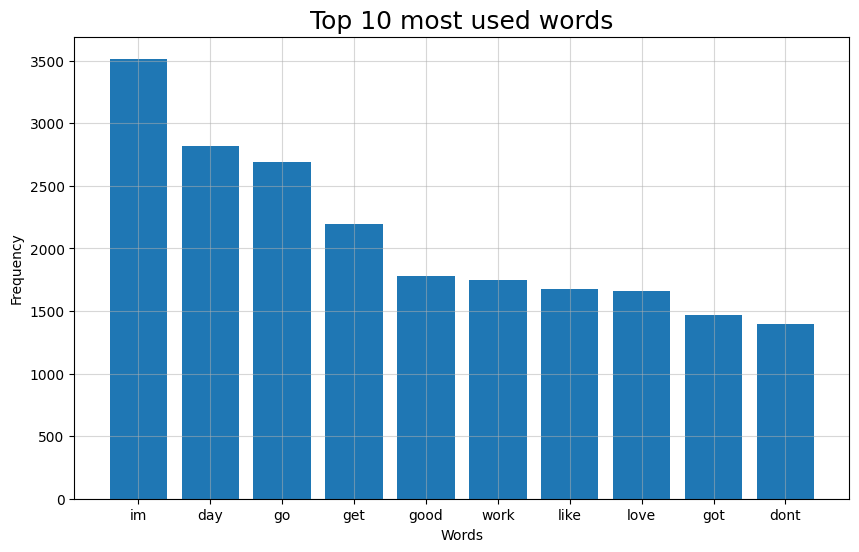

In [277]:
words = []
for text in X_train:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))

# Figure Size
plt.figure(figsize = (10, 6))

# Create the Barplot
plt.bar(range(len(top_words)), list(top_words.values()), align = 'center')

# Creating a y axis with words
plt.xticks(range(len(top_words)), list(top_words.keys()))

# Grid Opacity
plt.grid(alpha = 0.5)

# Title and labels
plt.title('Top 10 most used words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

<Axes: xlabel='sentiment'>

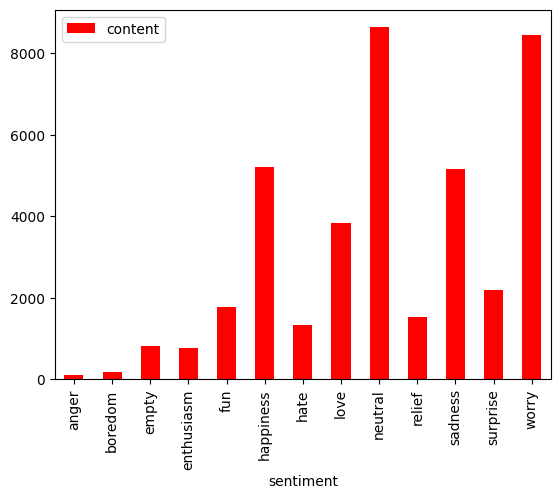

In [278]:
data.groupby('sentiment').count().plot.bar(color='red')

Logistic regresssion

In [310]:
# Vectorization (using Bag-of-Words)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)


In [312]:
X_test=vectorizer.transform(X_test)

In [314]:
y_test=label_encoder.transform(y_test)

In [311]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have the preprocessed features (X) and sentiment labels (y)


# Create a logistic regression model
model = LogisticRegression()




accuracy

In [315]:
# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.335625
Precision: 0.30549588124942684
Recall: 0.335625
F1-score: 0.3089420532267192
Accuracy: 0.335625
Precision: 0.30549588124942684
Recall: 0.335625
F1-score: 0.3089420532267192


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

lstm

In [283]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import SnowballStemmer
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [284]:
max_words = 10000
max_len = 100
# Tokenizer
tokenizer = Tokenizer(num_words = max_words)
# Snap tokenizer to text data
tokenizer.fit_on_texts(X_train)
# Converts texts into strings of numbers
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_test)
# Mapping words to indexes
word_index = tokenizer.word_index

In [285]:
# Sequence padding
data_train = pad_sequences(sequences_train, maxlen = max_len)
data_val = pad_sequences(sequences_val, maxlen = max_len)

In [286]:
# Create the model
model = tf.keras.Sequential()
model.add(Embedding(max_words, 16, input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Checking summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_________________________________________________________________


In [287]:
history = model.fit(data_train,y_train, epochs =10, batch_size = 64, validation_data = (data_val,y_test))

Epoch 1/10


UnimplementedError: ignored

preprocessing

In [99]:
#converting data in text column to string
data.content=data.content.astype(str)
#removing neutral categories
train_dataset_without_neutral = data[data.sentiment!="neutral"]
train_dataset_without_neutral.text=data.content.astype(str)
#converting train_dataset and train_dataset_without neutral to lower case

train_dataset_without_neutral.text = train_dataset_without_neutral.text.str.lower()
#cleaning more
data['content'] = data['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
train_dataset_without_neutral['content'] = train_dataset_without_neutral['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


<ipython-input-99-d9c6081fa8ff>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train_dataset_without_neutral.text=data.content.astype(str)
<ipython-input-99-d9c6081fa8ff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset_without_neutral['content'] = train_dataset_without_neutral['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))


<Axes: xlabel='sentiment'>

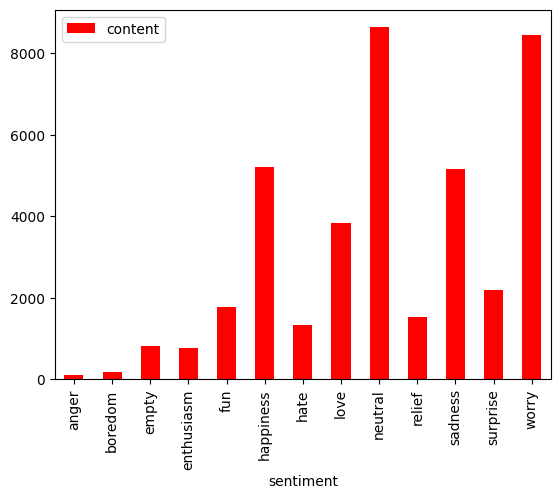

In [100]:
max_features = 5000
# removing unneccessary punctuations while tokenizing
tokenizer = Tokenizer(num_words= max_features, oov_token='OOV',filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~')
tokenizer.fit_on_texts(data['content'].values)
features2 = tokenizer.texts_to_sequences(data['content'].values)
features2 = pad_sequences(features2,padding='post')

In [101]:
#getting numerical data for labels
labels = pd.get_dummies(data['sentiment']).values
X_train, X_val, Y_train, Y_val = train_test_split(features2,labels, test_size = 0.33, random_state = 42)

print("Input training features and label shape are {},{}".format(X_train.shape,Y_train.shape))
print("Input validation features and label shape are {}, {}".format(X_val.shape,Y_val.shape))

Input training features and label shape are (26800, 33),(26800, 13)
Input validation features and label shape are (13200, 33), (13200, 13)


In [51]:
embedding_dimension = 128
LSTM_model = Sequential()
LSTM_model.add(Embedding(max_features, embedding_dimension, input_length = features2.shape[1]))
LSTM_model.add(SpatialDropout1D(0.4))
LSTM_model.add(LSTM(128, kernel_regularizer=l2(0.1),  dropout=0.4,recurrent_dropout=0.4))
LSTM_model.add(Dense(13, activation='softmax'))
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 33, 128)           640000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 33, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 13)                1677      
                                                                 
Total params: 773,261
Trainable params: 773,261
Non-trainable params: 0
_________________________________________________________________


In [52]:
batch_size = 256
LSTM_model_history = LSTM_model.fit(X_train,Y_train, epochs = 10, batch_size=batch_size, verbose=1, shuffle=True,validation_data=(X_val,Y_val))


Epoch 1/10
105/105 [==============================] - 55s 469ms/step - loss: 7.5285 - accuracy: 0.2110 - val_loss: 2.3722 - val_accuracy: 0.2208
Epoch 2/10
105/105 [==============================] - 50s 471ms/step - loss: 2.1871 - accuracy: 0.2116 - val_loss: 2.1480 - val_accuracy: 0.2186
Epoch 3/10
105/105 [==============================] - 51s 482ms/step - loss: 2.1486 - accuracy: 0.2141 - val_loss: 2.1461 - val_accuracy: 0.2186
Epoch 4/10
105/105 [==============================] - 48s 462ms/step - loss: 2.1489 - accuracy: 0.2141 - val_loss: 2.1472 - val_accuracy: 0.2186
Epoch 5/10
105/105 [==============================] - 53s 507ms/step - loss: 2.1480 - accuracy: 0.2110 - val_loss: 2.1471 - val_accuracy: 0.2094
Epoch 6/10
105/105 [==============================] - 56s 531ms/step - loss: 2.1478 - accuracy: 0.2153 - val_loss: 2.1475 - val_accuracy: 0.2186
Epoch 7/10
105/105 [==============================] - 51s 486ms/step - loss: 2.1475 - accuracy: 0.2147 - val_loss: 2.1473 - val_ac

ensemble

In [75]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [86]:
import numpy as np

In [102]:
X_train=np.array(X_train).tolist()

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the tweet text
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)


AttributeError: ignored

In [83]:
# Create a bag-of-words representation of the reviews
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(X_train)
test_features = vectorizer.transform(X_val)

AttributeError: ignored

In [81]:
# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train,Y_train)

RandomForestClassifier()

In [82]:
# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,Y_train)

ValueError: ignored